In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [38]:
# Use a raw string (r) to define the file path
# Load histogram data
histogram_file =  r'Yale_229_4039030_Histogram_Hourly.csv'  # replace with your actual file path
histogram_df = pd.read_csv(histogram_file)

# Convert 'Region start time' to a datetime object
# Assuming 'Region start time' is in a recognizable format, otherwise specify the format
histogram_df['Region start time'] = pd.to_datetime(histogram_df['Region start time'])
histogram_df

,Patient ID,Device ID,Region start time,Time zone,UTC start time,Pattern A Channel 1,Pattern A Channel 2,Pattern B Channel 1,Pattern B Channel 2,Episode starts,Episode starts with RX,Long episodes,Magnet swipes,Saturations,Hist hours,Mag sat hours
0,4039030,192517,2016-05-12 11:00:00,US/Eastern,2016-05-12 15:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,NaN
1,4039030,192517,2016-05-12 12:00:00,US/Eastern,2016-05-12 16:00:00.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,NaN
2,4039030,192517,2016-05-12 13:00:00,US/Eastern,2016-05-12 17:00:00.000,2.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,1,1.0
3,4039030,192517,2016-05-12 14:00:00,US/Eastern,2016-05-12 18:00:00.000,0.0,0.0,0.0,3.0,3.0,0.0,2.0,0.0,0.0,1,1.0
4,4039030,192517,2016-05-12 15:00:00,US/Eastern,2016-05-12 19:00:00.000,2.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37870,4039030,208052,2020-09-06 08:00:00,US/Eastern,2020-09-06 12:00:00.000,5.0,8.0,7.0,9.0,27.0,0.0,0.0,0.0,0.0,1,1.0
37871,4039030,208052,2020-09-06 09:00:00,US/Eastern,2020-09-06 13:00:00.000,5.0,21.0,20.0,18.0,60.0,0.0,0.0,0.0,0.0,1,1.0
37872,4039030,208052,2020-09-06 10:00:00,US/Eastern,2020-09-06 14:00:00.000,5.0,19.0,8.0,27.0,58.0,0.0,0.0,0.0,0.0,1,1.0
37873,4039030,208052,2020-09-06 11:00:00,US/Eastern,2020-09-06 15:00:00.000,5.0,3.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1,1.0


In [13]:
# Use a raw string (r) to define the file path
# Load epic data
epic_file = r'epoch_list.csv' # replace with your actual file path
epic_df = pd.read_csv(epic_file)

# Convert Unix time to human-readable format
epic_df['PROGRAMMING_DATE_GMT_SEC'] = pd.to_datetime(epic_df['PROGRAMMING_DATE_GMT_SEC'], unit='s')

/tmp/ipykernel_52520/1330245909.py:4: DtypeWarning: Columns (99,100,104,105,106,107,211,236,240,241,246,248,257,270,304,321,383,396,413,416,417,419,420,490,497,498,499,500,501,502,503,504,505,514,515,516,517,518,519,520,521,522,563,564,566,569,575,578,593,596,637,645,688,731,774,817,863,865,931,945) have mixed types. Specify dtype option on import or set low_memory=False.
  epic_df = pd.read_csv(epic_file)


In [14]:
# Filter for the specific patient
patient_at_center_id = 23879984  # replace with actual patient ID
filtered_epic_df = epic_df[epic_df['PATIENT_AT_CENTER_ID'] == patient_at_center_id]

In [39]:
# Select specific columns of interest
selected_columns = ['DETSUMMARY', 'DET_PARAMS_CHANGED', 'PROGRAMMING_DATE_GMT_SEC']

# Filter the epic data to include only rows where 'DET_PARAMS_CHANGED' is True
filtered_epic_df = epic_df[epic_df['DET_PARAMS_CHANGED'] == True][selected_columns]

# Convert 'PROGRAMMING_DATE_GMT_SEC' to a datetime format
filtered_epic_df['PROGRAMMING_DATE_GMT_SEC'] = pd.to_datetime(filtered_epic_df['PROGRAMMING_DATE_GMT_SEC'], unit='s')
filtered_epic_df

,DETSUMMARY,DET_PARAMS_CHANGED,PROGRAMMING_DATE_GMT_SEC
2,Detection Settings,True,2018-06-25 14:45:42
10,Detection Settings,True,2016-02-19 17:01:46
16,Detection Settings,True,2019-06-11 16:03:26
19,Detection Settings,True,2018-05-10 20:23:27
23,Detection Settings,True,2016-06-16 13:46:19
...,...,...,...
1008,Detection Settings,True,2023-07-17 20:50:17
1015,Detection Settings,True,2023-02-06 15:55:09
1032,Detection Settings,True,2023-06-08 12:17:56
1036,Detection Settings,True,2015-10-21 19:25:38


In [22]:
# Initialize a new DataFrame to store aligned data
aligned_data = pd.DataFrame()

# Iterate over each parameter change date in the filtered epic data
for index, row in filtered_epic_df.iterrows():
    param_change_time = row['PROGRAMMING_DATE_GMT_SEC']
    window_start = param_change_time - pd.Timedelta(hours=24)  # Define the window start time
    window_end = param_change_time + pd.Timedelta(hours=24)    # Define the window end time

    # Filter histogram data within the defined window
    window_data = histogram_df[(histogram_df['Region start time'] >= window_start) & 
                               (histogram_df['Region start time'] <= window_end)]
    
    # Add columns to indicate the parameter change, its summary, and whether parameters were changed
    window_data['Param_Change_Date'] = param_change_time
    window_data['DETSUMMARY'] = row['DETSUMMARY']
    window_data['DET_PARAMS_CHANGED'] = row['DET_PARAMS_CHANGED']

    # Append to the aligned data DataFrame
    aligned_data = pd.concat([aligned_data, window_data], ignore_index=True)


/tmp/ipykernel_52520/741980464.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_data['Param_Change_Date'] = param_change_time
/tmp/ipykernel_52520/741980464.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_data['DETSUMMARY'] = row['DETSUMMARY']
/tmp/ipykernel_52520/741980464.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [7]:
# Apply logarithmic transformation to 'Long episodes' and create 'Log Long episodes' column
aligned_data['Log Long episodes'] = np.log1p(aligned_data['Long episodes'])

In [20]:
# Fill missing values in aligned_data
# Option 1: Fill with 0 or another appropriate value
aligned_data.fillna(0, inplace=True)

# Option 2: Fill with mean/median (for numerical columns)
# for col in feature_cols:
#     aligned_data[col].fillna(aligned_data[col].mean(), inplace=True)

In [26]:
aligned_data


,Patient ID,Device ID,Region start time,Time zone,UTC start time,Pattern A Channel 1,Pattern A Channel 2,Pattern B Channel 1,Pattern B Channel 2,Episode starts,Episode starts with RX,Long episodes,Magnet swipes,Saturations,Hist hours,Mag sat hours,Param_Change_Date,DETSUMMARY,DET_PARAMS_CHANGED
0,4039030,192517,2018-06-24 15:00:00,US/Eastern,2018-06-24 19:00:00.000,16.0,0.0,78.0,0.0,92.0,91.0,1.0,NaN,NaN,1,NaN,2018-06-25 14:45:42,Detection Settings,True
1,4039030,192517,2018-06-24 16:00:00,US/Eastern,2018-06-24 20:00:00.000,12.0,0.0,72.0,0.0,78.0,79.0,2.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True
2,4039030,192517,2018-06-24 17:00:00,US/Eastern,2018-06-24 21:00:00.000,15.0,0.0,70.0,0.0,82.0,81.0,1.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True
3,4039030,192517,2018-06-24 18:00:00,US/Eastern,2018-06-24 22:00:00.000,30.0,0.0,51.0,0.0,77.0,78.0,3.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True
4,4039030,192517,2018-06-24 19:00:00,US/Eastern,2018-06-24 23:00:00.000,20.0,0.0,88.0,0.0,102.0,102.0,0.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,4039030,192517,2018-09-20 07:00:00,US/Eastern,2018-09-20 11:00:00.000,43.0,0.0,128.0,0.0,158.0,157.0,9.0,NaN,NaN,1,NaN,2018-09-19 11:57:24,Detection Settings,True
5134,4039030,192517,2018-09-20 08:00:00,US/Eastern,2018-09-20 12:00:00.000,58.0,0.0,122.0,0.0,160.0,160.0,18.0,0.0,0.0,1,1.0,2018-09-19 11:57:24,Detection Settings,True
5135,4039030,192517,2018-09-20 09:00:00,US/Eastern,2018-09-20 13:00:00.000,57.0,0.0,66.0,0.0,111.0,112.0,14.0,0.0,0.0,1,1.0,2018-09-19 11:57:24,Detection Settings,True
5136,4039030,192517,2018-09-20 10:00:00,US/Eastern,2018-09-20 14:00:00.000,34.0,0.0,55.0,0.0,83.0,83.0,3.0,0.0,0.0,1,1.0,2018-09-19 11:57:24,Detection Settings,True


In [28]:
# Checking the number of rows corresponding to the specific parameter change date '2018-06-25 14:45:42'
specific_date = '2018-06-25 14:45:42'
specific_date_count = aligned_data[aligned_data['Param_Change_Date'] == specific_date].shape[0]
specific_date_count

48

In [34]:
# Filter for the specific patient
patient_at_center_id = 23879984  # replace with actual patient ID
filtered_patient_df = epic_df[epic_df['PATIENT_AT_CENTER_ID'] == patient_at_center_id]

# Filter to include only rows where 'DET_PARAMS_CHANGED' is True and drop duplicates
unique_param_changes_df = filtered_patient_df[filtered_patient_df['DET_PARAMS_CHANGED'] == True].drop_duplicates()

# Select specific columns
columns_of_interest = ['PATIENT_AT_CENTER_ID', 'DETSUMMARY', 'DET_PARAMS_CHANGED', 'PROGRAMMING_DATE_GMT_SEC']
unique_param_changes_df = unique_param_changes_df[columns_of_interest]

# Displaying the first few rows of the new dataset
unique_param_changes_df

,PATIENT_AT_CENTER_ID,DETSUMMARY,DET_PARAMS_CHANGED,PROGRAMMING_DATE_GMT_SEC
545,23879984,Detection Settings,True,2019-10-24 19:49:15
546,23879984,Detection Settings,True,2019-08-01 21:19:29
547,23879984,Detection Settings,True,2019-07-09 11:25:21
548,23879984,Detection Settings,True,2019-05-09 16:19:47
557,23879984,Detection Settings,True,2018-05-17 21:17:16
568,23879984,Detection Settings,True,2016-11-03 13:45:30
572,23879984,Detection Settings,True,2016-05-19 14:08:56


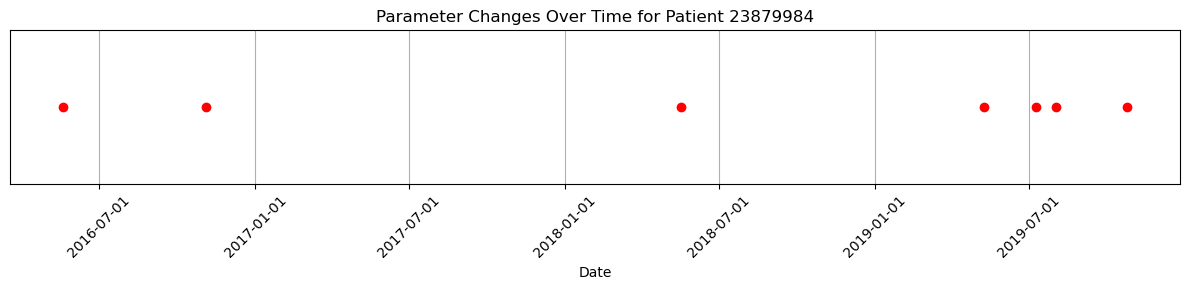

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming unique_param_changes_df is already loaded

# Convert 'PROGRAMMING_DATE_GMT_SEC' to datetime if it's not already
unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC'] = pd.to_datetime(unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC'])

# Plotting
plt.figure(figsize=(12, 3))
plt.scatter(unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC'], [1] * len(unique_param_changes_df), color='red')
plt.title('Parameter Changes Over Time for Patient 23879984')
plt.xlabel('Date')
plt.yticks([])  # Hides the y-axis as it's not informative in this context
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


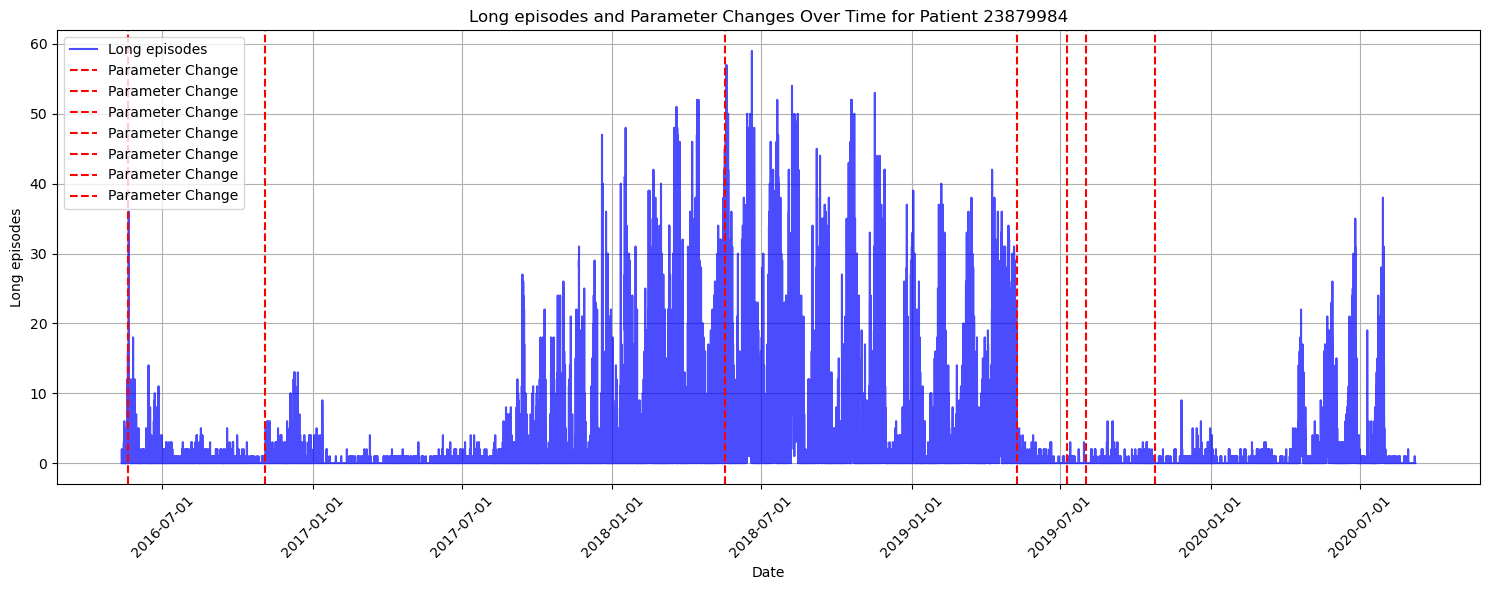

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming histogram_df and unique_param_changes_df are already loaded

# Select the metric - 'Long episodes' or 'Episode starts'
metric = 'Long episodes'  # or 'Episode starts'

# Convert 'Region start time' to datetime if it's not already
histogram_df['Region start time'] = pd.to_datetime(histogram_df['Region start time'])

# Plotting the metric over time
plt.figure(figsize=(15, 6))
plt.plot(histogram_df['Region start time'], histogram_df[metric], label=metric, color='blue', alpha=0.7)

# Overlaying parameter change dates
for change_date in unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC']:
    plt.axvline(x=change_date, color='red', linestyle='--', linewidth=1.5, label='Parameter Change')

# Enhancing the plot
plt.title(f'{metric} and Parameter Changes Over Time for Patient 23879984')
plt.xlabel('Date')
plt.ylabel(metric)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Parameter Change Dates:
545   2019-10-24 19:49:15
546   2019-08-01 21:19:29
547   2019-07-09 11:25:21
548   2019-05-09 16:19:47
557   2018-05-17 21:17:16
568   2016-11-03 13:45:30
572   2016-05-19 14:08:56
Name: PROGRAMMING_DATE_GMT_SEC, dtype: datetime64[ns]


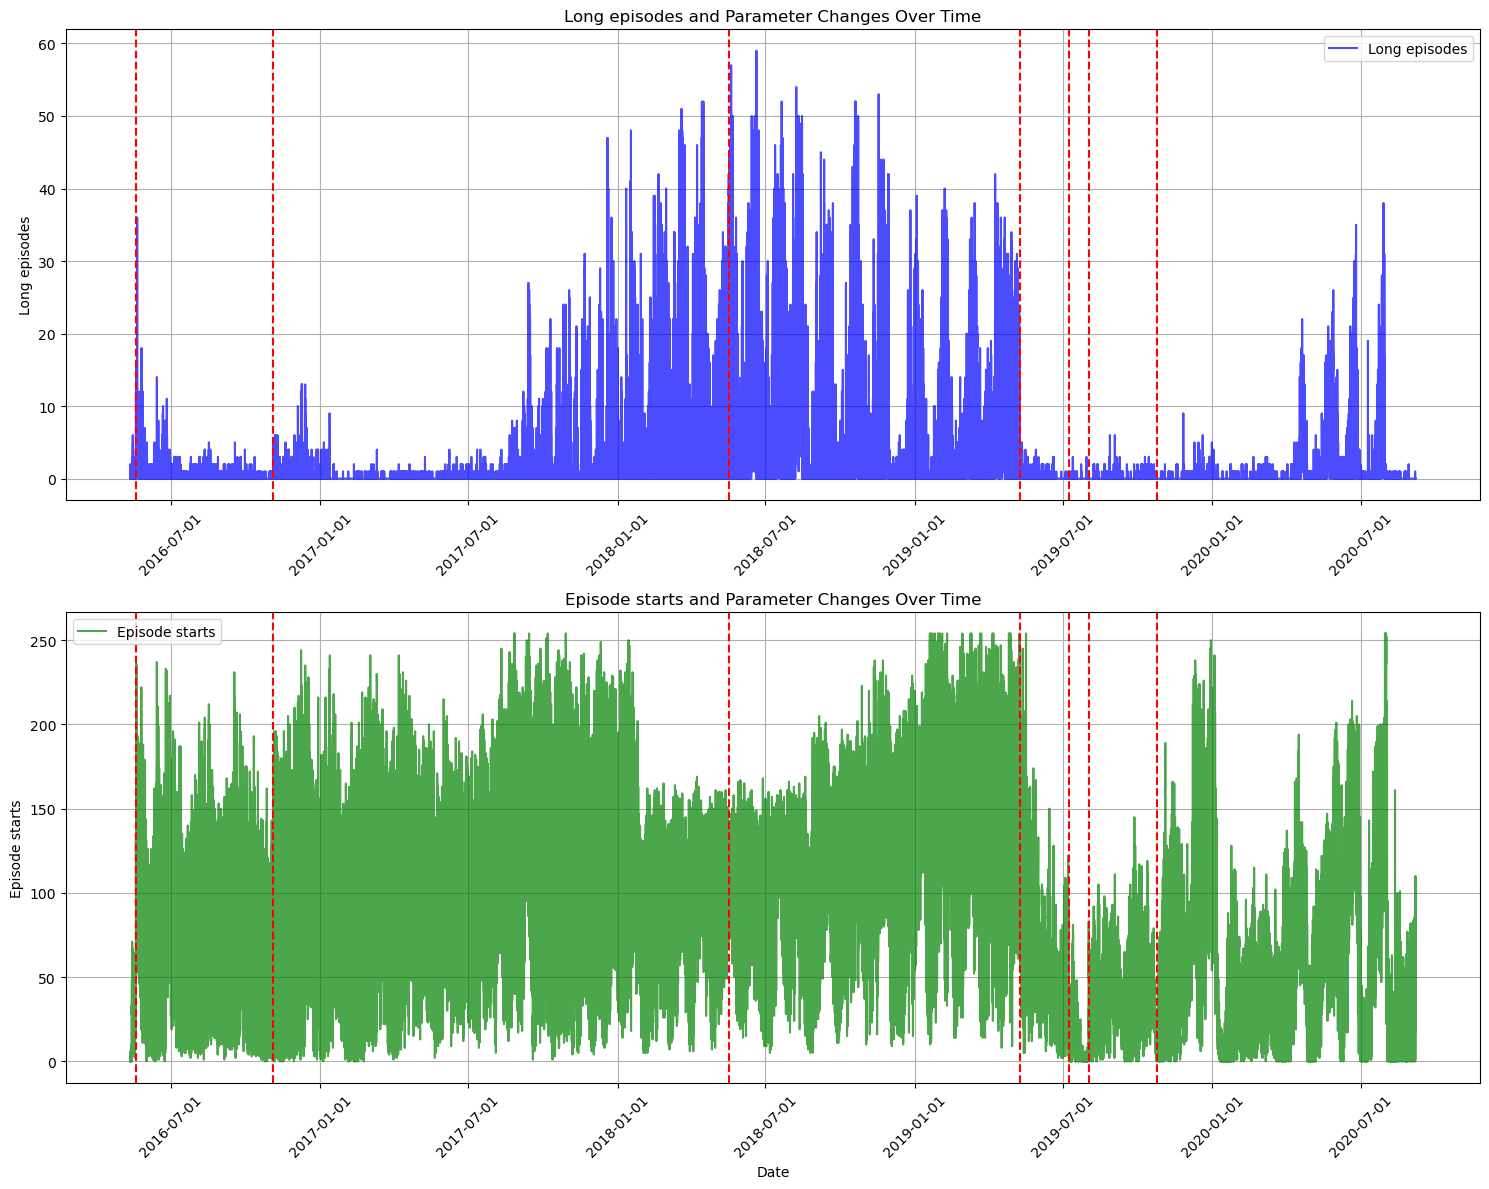

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming histogram_df and unique_param_changes_df are already loaded

# Metrics
metric_1 = 'Long episodes'
metric_2 = 'Episode starts'

# Print the parameter change dates
print("Parameter Change Dates:")
print(unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC'])

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# First subplot for 'Long episodes'
ax1.plot(histogram_df['Region start time'], histogram_df[metric_1], label=metric_1, color='blue', alpha=0.7)
for change_date in unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC']:
    ax1.axvline(x=change_date, color='red', linestyle='--', linewidth=1.5)
ax1.set_title(f'{metric_1} and Parameter Changes Over Time')
ax1.set_ylabel(metric_1)
ax1.legend()
ax1.grid(True)

# Second subplot for 'Episode starts'
ax2.plot(histogram_df['Region start time'], histogram_df[metric_2], label=metric_2, color='green', alpha=0.7)
for change_date in unique_param_changes_df['PROGRAMMING_DATE_GMT_SEC']:
    ax2.axvline(x=change_date, color='red', linestyle='--', linewidth=1.5)
ax2.set_title(f'{metric_2} and Parameter Changes Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel(metric_2)
ax2.legend()
ax2.grid(True)

# Format dates on x-axis
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Normalize Features Within Each Epic

In [10]:
from scipy.stats import zscore

# Define feature columns excluding 'Long episodes' and non-feature columns
non_feature_cols = ['Region start time', 'Param_Change_Date', 'DETSUMMARY', 'DET_PARAMS_CHANGED', 'Long episodes']
feature_cols = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2', 'Episode starts']

# Normalize features within each epic
for param_change_time in filtered_epic_df['PROGRAMMING_DATE_GMT_SEC'].unique():
    # Identify the data for the current epic
    epic_data = aligned_data[aligned_data['Param_Change_Date'] == param_change_time]

    # Apply z-score normalization
    for col in feature_cols:
        aligned_data.loc[epic_data.index, col] = zscore(epic_data[col])


In [11]:
aligned_data.head()

,Patient ID,Device ID,Region start time,Time zone,UTC start time,Pattern A Channel 1,Pattern A Channel 2,Pattern B Channel 1,Pattern B Channel 2,Episode starts,Episode starts with RX,Long episodes,Magnet swipes,Saturations,Hist hours,Mag sat hours,Param_Change_Date,DETSUMMARY,DET_PARAMS_CHANGED,Log Long episodes
0,4039030,192517,2018-06-24 15:00:00,US/Eastern,2018-06-24 19:00:00.000,-0.709984,NaN,0.615567,NaN,0.396654,91.0,1.0,0.0,0.0,1,0.0,2018-06-25 14:45:42,Detection Settings,True,0.693147
1,4039030,192517,2018-06-24 16:00:00,US/Eastern,2018-06-24 20:00:00.000,-1.012911,NaN,0.434481,NaN,-0.026444,79.0,2.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True,1.098612
2,4039030,192517,2018-06-24 17:00:00,US/Eastern,2018-06-24 21:00:00.000,-0.785716,NaN,0.374119,NaN,0.094441,81.0,1.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True,0.693147
3,4039030,192517,2018-06-24 18:00:00,US/Eastern,2018-06-24 22:00:00.000,0.350259,NaN,-0.199320,NaN,-0.056665,78.0,3.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True,1.386294
4,4039030,192517,2018-06-24 19:00:00,US/Eastern,2018-06-24 23:00:00.000,-0.407058,NaN,0.917377,NaN,0.698867,102.0,0.0,0.0,0.0,1,1.0,2018-06-25 14:45:42,Detection Settings,True,0.000000


Normalize Data Within Each Epic (with Z-Score Tracking)

In [12]:
from scipy.stats import zscore

# Define feature columns excluding 'Long episodes' and non-feature columns
non_feature_cols = ['Region start time', 'Param_Change_Date', 'DETSUMMARY', 'DET_PARAMS_CHANGED', 'Long episodes']
feature_cols = ['Pattern A Channel 1', 'Pattern A Channel 2', 'Pattern B Channel 1', 'Pattern B Channel 2', 'Episode starts']

# Dictionary to store z-scores for each epic
epic_z_scores = {}

# Normalize features within each epic and store the z-scores
for param_change_time in filtered_epic_df['PROGRAMMING_DATE_GMT_SEC'].unique():
    # Identify the data for the current epic
    epic_data = aligned_data[aligned_data['Param_Change_Date'] == param_change_time]
    epic_z_scores[param_change_time] = {}

    for col in feature_cols:
        # Calculate z-score
        z_scores = zscore(epic_data[col])
        
        # Update the aligned_data with normalized values
        aligned_data.loc[epic_data.index, col] = z_scores

        # Store the z-scores in the dictionary
        epic_z_scores[param_change_time][col] = z_scores

In [ ]:
 #epic_z_scores

Negative values in  z-score normalized data are normal and expected, especially when the original values in a feature column vary around their mean. Z-score normalization centers the data around the mean (which becomes 0) and scales it in terms of standard deviation (which becomes 1). So, any original value below the mean of that feature becomes negative after normalization.

Another way is to use - Min-Max Normalization: Scales the data to a fixed range, typically 0 to 1. This ensures all values are positive but can be sensitive to outliers. 

In [13]:
# Fill NaN values in the DataFrame. Here, I'm using 0, but you might choose a different strategy.
aligned_data.fillna(0, inplace=True)

Prepare Data for LSTM Model Training

In [14]:
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24  # Adjust based on your temporal context
features = aligned_data[feature_cols].values  # Extracting feature columns as numpy array
target = aligned_data['Log Long episodes'].values  # Extracting target column as numpy array

X, y = create_sequences(features, target, sequence_length)

Define LSTM Model

In [17]:
# model has no stop of overfitting 
#from tensorflow.keras.models import Sequential
#From tensorflow.keras.layers import LSTM, Dense

#model = Sequential()
#model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(feature_cols))))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(feature_cols))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Include an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Train LSTM Model

In [16]:
model.fit(X, y, epochs=30, batch_size=32)

Epoch 1/30
160/160 [==============================] - 3s 8ms/step - loss: 0.8578
Epoch 2/30
160/160 [==============================] - 1s 7ms/step - loss: 0.7173
Epoch 3/30
160/160 [==============================] - 1s 7ms/step - loss: 0.6784
Epoch 4/30
160/160 [==============================] - 1s 7ms/step - loss: 0.6587
Epoch 5/30
160/160 [==============================] - 1s 7ms/step - loss: 0.6277
Epoch 6/30
160/160 [==============================] - 1s 7ms/step - loss: 0.5974
Epoch 7/30
160/160 [==============================] - 1s 7ms/step - loss: 0.5926
Epoch 8/30
160/160 [==============================] - 1s 7ms/step - loss: 0.5730
Epoch 9/30
160/160 [==============================] - 1s 7ms/step - loss: 0.5575
Epoch 10/30
160/160 [==============================] - 1s 7ms/step - loss: 0.5392
Epoch 11/30
160/160 [==============================] - 1s 7ms/step - loss: 0.5227
Epoch 12/30
160/160 [==============================] - 1s 7ms/step - loss: 0.4960
Epoch 13/30
160/160 [====

Evaluate Model

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


160/160 [==============================] - 1s 4ms/step
Mean Absolute Error (MAE): 0.3715271682114471
Root Mean Squared Error (RMSE): 0.560763021276913


Visualize the Actual vs. Predicted Values

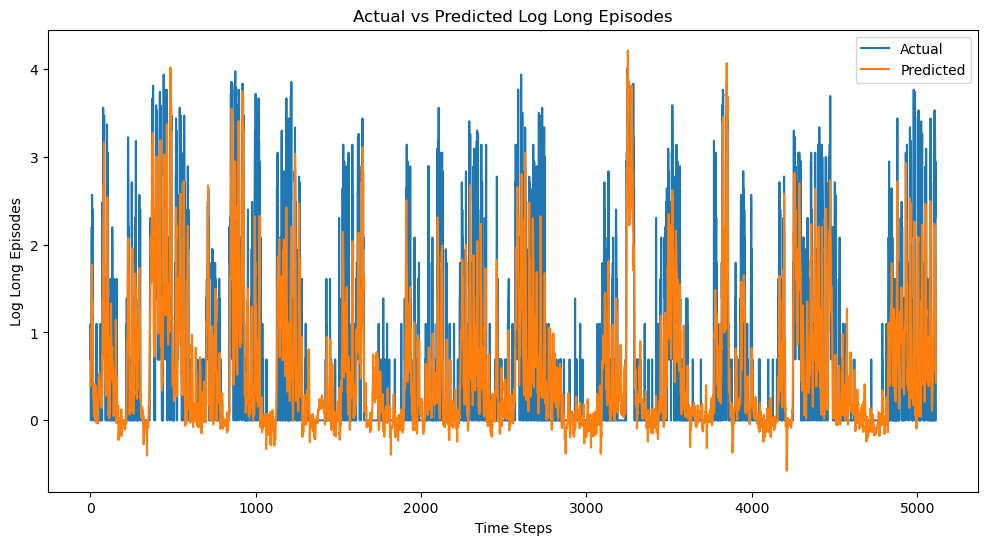

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Log Long Episodes')
plt.xlabel('Time Steps')
plt.ylabel('Log Long Episodes')
plt.legend()
plt.show()

Forecasting Seizures for the Next 24 Hours

In [19]:
# Function to make a single prediction using the last sequence of data
def make_single_prediction(model, last_sequence):
    last_sequence = last_sequence.reshape((1, sequence_length, len(feature_cols)))
    predicted_value = model.predict(last_sequence)
    return predicted_value[0, 0]

# Get the last sequence of data
last_sequence = features[-sequence_length:]

# Initialize a list to store the forecasts
forecasts = []

# Forecast for the next 24 hours
for i in range(24):
    predicted_value = make_single_prediction(model, last_sequence)
    forecasts.append(predicted_value)

    # Update the last sequence with the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1, :] = np.zeros(len(feature_cols))  # Assuming all features are 0 for future points
    # No need to update the target variable in the sequence as it's not used for future predictions

# Reverse the log transformation (if needed)
forecasts_reversed = np.expm1(forecasts)

# Print the forecasted values
print("Forecasted Seizures for the Next 24 Hours:")
print(forecasts_reversed)

1/1 [==============================] - 0s 31ms/step
Forecasted Seizures for the Next 24 Hours:
[0.4780781  0.54410356 0.45271677 0.349884   0.30950975 0.2619521
 0.25138777 0.25081232 0.26004452 0.284944   0.34045044 0.46348447
 2.3542612  2.8602564  3.125668   3.6685276  3.7167575  4.010118
 3.5106263  3.7522154  3.370067   2.9902034  3.0788453  2.9305816 ]


Forecast Values: Each number in the array represents the forecasted value of seizures (in the original scale, since we reversed the log transformation) for each of the next 24 hours. For instance, the first value 0.6379802 is the predicted number of seizures for the first hour, 0.5930065 for the second hour, and so on.

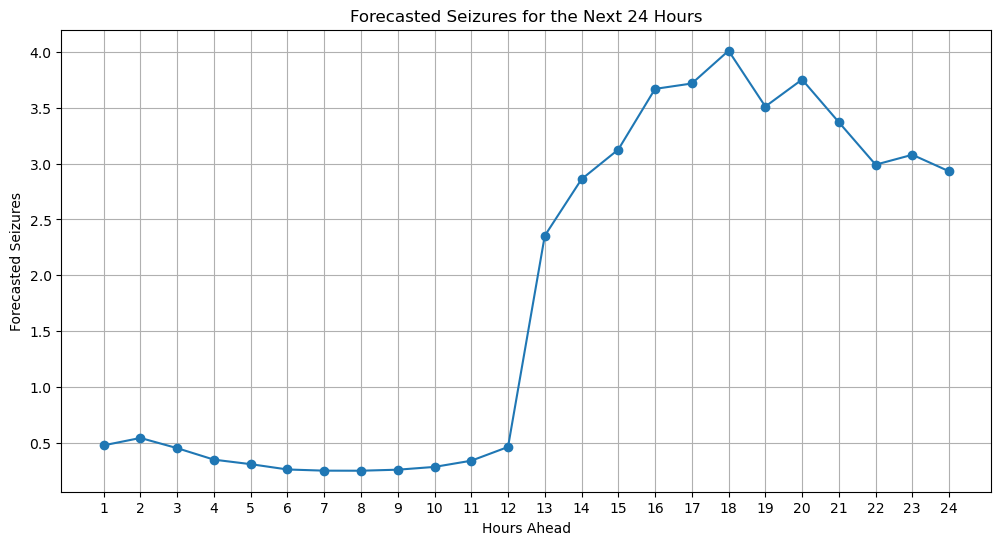

In [20]:
hours_ahead = np.arange(1, 25)  # 1 to 24 hours ahead
plt.figure(figsize=(12, 6))
plt.plot(hours_ahead, forecasts_reversed, marker='o', linestyle='-')
plt.title('Forecasted Seizures for the Next 24 Hours')
plt.xlabel('Hours Ahead')
plt.ylabel('Forecasted Seizures')
plt.xticks(hours_ahead)
plt.grid(True)
plt.show()


# Try 2 -  Adding Dropout and Regularization

Implementing Cross-Validation for Time Series Data

Epoch 1/30
6/6 [==============================] - 2s 12ms/step - loss: 0.7106
Epoch 2/30
6/6 [==============================] - 0s 11ms/step - loss: 0.3845
Epoch 3/30
6/6 [==============================] - 0s 11ms/step - loss: 0.1809
Epoch 4/30
6/6 [==============================] - 0s 10ms/step - loss: 0.1087
Epoch 5/30
6/6 [==============================] - 0s 9ms/step - loss: 0.1046
Epoch 6/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0968
Epoch 7/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0956
Epoch 8/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0987
Epoch 9/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0926
Epoch 10/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0992
Epoch 11/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0861
Epoch 12/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0816
Epoch 13/30
6/6 [==============================] - 0s 8ms/step - loss

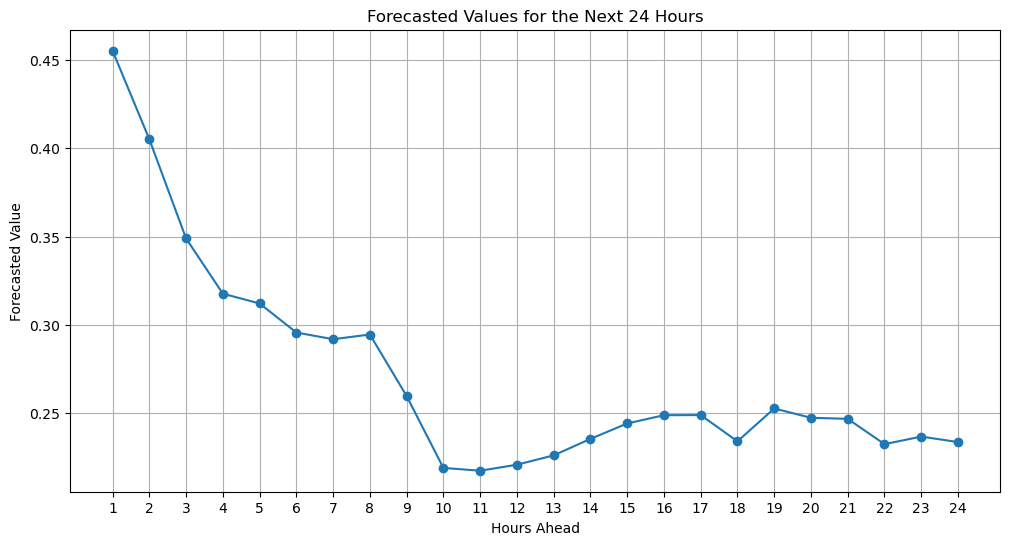

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import zscore

# Dummy data generation for illustration purposes
# Replace this with your actual data loading and preprocessing
num_samples = 1000
sequence_length = 24
num_features = 5

np.random.seed(0)
features = np.random.rand(num_samples, num_features)
target = np.random.rand(num_samples)  # Replace with your actual target variable

# Create sequences for LSTM
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

X, y = create_sequences(features, target, sequence_length)

# Define LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, num_features)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# TimeSeries Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on training data
    model.fit(X_train, y_train, epochs=30, batch_size=32)

    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold MAE: {mae}, RMSE: {rmse}")

# Forecast for the next 24 hours
last_sequence = features[-sequence_length:]  # Extract the last sequence of known data

def make_single_prediction(model, last_sequence):
    last_sequence = last_sequence.reshape((1, sequence_length, num_features))
    predicted_value = model.predict(last_sequence)
    return predicted_value[0, 0]

forecasts = []

for _ in range(24):
    predicted_value = make_single_prediction(model, last_sequence)
    forecasts.append(predicted_value)

    # Update the last sequence with the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1, :] = np.zeros(num_features)  # Assuming all features are 0 for future points
    last_sequence[-1, -1] = predicted_value

# Print the forecasted values
print("Forecasted Values for the Next 24 Hours:")
print(forecasts)

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(range(1, 25), forecasts, marker='o', linestyle='-')
plt.title('Forecasted Values for the Next 24 Hours')
plt.xlabel('Hours Ahead')
plt.ylabel('Forecasted Value')
plt.xticks(range(1, 25))
plt.grid(True)
plt.show()


Create LSTM Model Function

In [39]:
def create_lstm_model(input_shape, output_dim=1):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(output_dim))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Time Series Cross-Validation

In [40]:
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

    model = create_lstm_model((sequence_length, len(feature_cols)))
    model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stopping])

    y_pred = model.predict(X_test_seq)
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)


Epoch 1/30
27/27 [==============================] - 2s 23ms/step - loss: 1.2648 - val_loss: 1.0225
Epoch 2/30
27/27 [==============================] - 0s 12ms/step - loss: 0.9625 - val_loss: 0.8751
Epoch 3/30
27/27 [==============================] - 0s 12ms/step - loss: 1.1277 - val_loss: 0.9204
Epoch 4/30
27/27 [==============================] - 0s 11ms/step - loss: 1.0106 - val_loss: 0.9379
Epoch 5/30
27/27 [==============================] - 0s 11ms/step - loss: 0.9281 - val_loss: 0.9075
Epoch 6/30
27/27 [==============================] - 0s 11ms/step - loss: 0.8688 - val_loss: 0.8116
Epoch 7/30
27/27 [==============================] - 0s 11ms/step - loss: 0.7725 - val_loss: 0.8765
Epoch 8/30
27/27 [==============================] - 0s 11ms/step - loss: 0.7394 - val_loss: 0.7289
Epoch 9/30
27/27 [==============================] - 0s 11ms/step - loss: 0.7296 - val_loss: 0.7368
Epoch 10/30
27/27 [==============================] - 0s 11ms/step - loss: 0.6667 - val_loss: 0.7467
Epoch 11/

In [41]:
# Calculate average performance across all folds
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)

print(f"Average Mean Absolute Error (MAE): {average_mae}")
print(f"Average Root Mean Squared Error (RMSE): {average_rmse}")


Average Mean Absolute Error (MAE): 0.6207058757026263
Average Root Mean Squared Error (RMSE): 0.8718808149037491
